## ISBI2020 presentation

### Introduction
#### Submission (654) Software tool to read, represent, manipulate and apply $n$-dimensional spatial transforms
Spatial transforms formalize mappings between coordinates of objects in biomedical images. Transforms typically are the outcome of image registration methodologies, which estimate the alignment between two images. Image registration is a prominent task present in nearly all standard image processing and analysis pipelines. The proliferation of software implementations of image registration methodologies has resulted in a spread of data structures and file formats used to preserve and communicate transforms. This segregation of formats hinders the compatibility between tools and endangers the reproducibility of results. We propose a software tool capable of converting between formats and resampling images to apply transforms generated by the most popular neuroimaging packages and libraries (AFNI, FSL, FreeSurfer, ITK, and SPM). The proposed software is subject to continuous integration tests to check the compatibility with each supported tool after every change to the [code base](https://github.com/nipy/nitransforms). Compatibility between software tools and imaging formats is a necessary bridge to ensure the reproducibility of results and enable the optimization and evaluation of current image processing and analysis workflows.

The process is summarized in the following figure:
![alt text](../_static/figure1-joss.png "Figure 1")

In [2]:
import os
from pathlib import Path
import nibabel as nb
from niworkflows.viz.notebook import display
import nitransforms as not
from nitransforms.resampling import apply

In [3]:
print(nt.__version__)
DATA_PATH = Path(os.getenv("NT_TEST_DATA", "~/.nitransforms/testdata")).expanduser().absolute()

20.0.0rc2


### Step 0: Load some data
We are going to load a structural T1w image and an average through time of a BOLD fMRI dataset. Both belong to participant `sub-01` of https://openneuro.org/datasets/ds000005.

We first check that each image has a different extent and sampling grid, using nibabel.

In [4]:
t1w_nii = nb.load(DATA_PATH / "T1w_scanner.nii.gz")
print(t1w_nii.affine)
print(t1w_nii.shape)

[[   1.            0.            0.          -81.        ]
 [   0.            1.33333302    0.         -133.        ]
 [   0.            0.            1.33333302 -129.        ]
 [   0.            0.            0.            1.        ]]
(160, 192, 192)


In [5]:
bold_nii = nb.load(DATA_PATH / "bold.nii.gz")
print(bold_nii.affine)
print(bold_nii.shape)

[[ -3.125   0.      0.    101.   ]
 [  0.      3.125   0.    -72.   ]
 [  0.      0.      4.    -99.   ]
 [  0.      0.      0.      1.   ]]
(64, 64, 34)


### Step 1: Check they are not aligned
Let's use NiTransforms to resample the BOLD image in the T1w's space. We can do that just applying an identity transform.

In [6]:
identity_xfm = nt.linear.Affine(reference=t1w_nii)
identity_xfm.matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [7]:
resampled_in_t1 = apply(identity_xfm, bold_nii)
print(resampled_in_t1.affine)
print(resampled_in_t1.shape)

[[   1.            0.            0.          -81.        ]
 [   0.            1.33333302    0.         -133.        ]
 [   0.            0.            1.33333302 -129.        ]
 [   0.            0.            0.            1.        ]]
(160, 192, 192)


As it can be seen above, after applying the identity transform both datasets have the same structure (i.e., they are sampled exactly the same way and their internal data matrices have samples at the same locations of the physical extent they represent). However, **the information in the images is not aligned** (i.e., the brain structures captured by the functional signal and the T1w signal are not aligned).

In [8]:
display(t1w_nii, resampled_in_t1)

### Step 2: Image registration
Let's use the FreeSurfer's `bbregister` image registration tool to estimate a function that maps the space of the T1w image to that of the BOLD image. That way we will be able to bring both brains into alignment.

The test data folder contains the result of the process, with the LTA format - which is unique of FreeSurfer (as in, no other software utilizes it).

In [9]:
t1w_to_bold_xfm = nt.linear.load(DATA_PATH / "from-scanner_to-bold_mode-image.lta", fmt="fs")
t1w_to_bold_xfm.reference = t1w_nii

In [10]:
moved_to_t1 = apply(t1w_to_bold_xfm, bold_nii)
print(moved_to_t1.affine)
print(moved_to_t1.shape)

[[   1.            0.            0.          -81.        ]
 [   0.            1.33333302    0.         -133.        ]
 [   0.            0.            1.33333302 -129.        ]
 [   0.            0.            0.            1.        ]]
(160, 192, 192)


In [11]:
display(t1w_nii, moved_to_t1)

Say we want to do the opposite: bring some information/knowledge we have in T1w space (e.g., a manual segmentation or annotation) into the BOLD data grid. We would need to have the transform in the other way around. That's pretty easy with the inverse (`~`) operator:

In [12]:
bold_to_t1w_xfm = ~t1w_to_bold_xfm
bold_to_t1w_xfm.reference = bold_nii

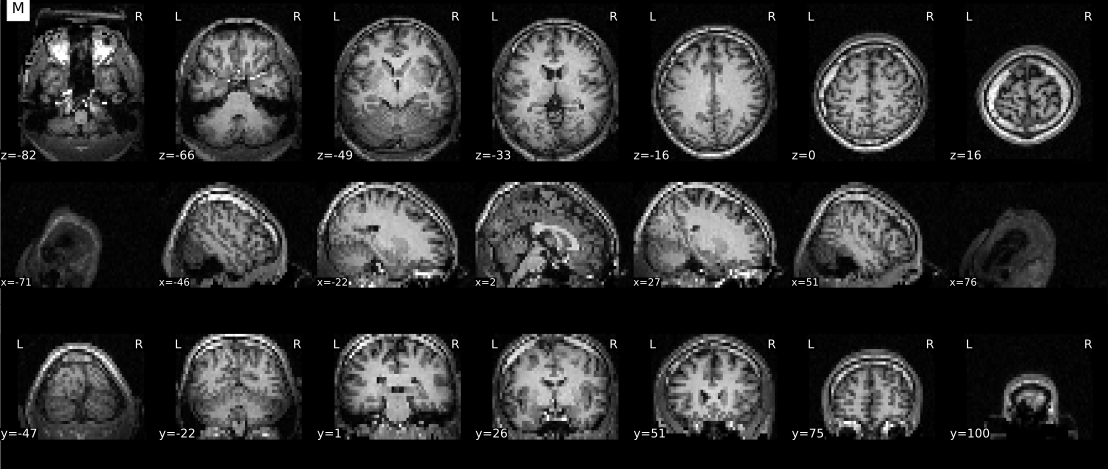

In [13]:
display(bold_nii, apply(bold_to_t1w_xfm, t1w_nii))

### Final notes
#### Installation
```Python
pip install nitransforms
```
See also: https://github.com/nipy/nitransforms